In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
from mpl_toolkits.mplot3d import Axes3D


In [2]:
df = pd.read_csv('dog_breeds.csv')

In [3]:
print(df.columns)

df.head()

Index(['Breed Name', 'Weight(g)', 'Height(cm)', 'Longevity(yrs)',
       'Energy level', 'Attention Needs', 'Coat Lenght', 'Sex', 'Owner Name'],
      dtype='object')


,Breed Name,Weight(g),Height(cm),Longevity(yrs),Energy level,Attention Needs,Coat Lenght,Sex,Owner Name
0,Australian Shepherd,21041.6994,NaN,12.9971,high,high,short,male,Rodriguez
1,Pit Bull,16991.8668,45.1886,12.0789,med,high,short,female,Hughes
2,Boxer,28429.3520,57.4321,9.7405,high,med,short,female,Jimenez
3,French Bulldog,11793.2472,NaN,10.6215,med,high,short,male,Ortiz
4,Australian Shepherd,26746.6297,NaN,12.9608,high,high,med,male,Blake


In [4]:
column_renames = {
    'Breed Name': 'breed_name',
    'Weight(g)': 'weight',
    'Height(cm)': 'height',
    'Longevity(yrs)': 'longevity',
    'Energy level': 'energy_level',
    'Attention Needs': 'attention_needs',
    'Coat Lenght': 'coat_lenght',
    'Sex': 'sex',
    'Owner Name': 'owner_name'
}
df = df.rename(index=str, columns=column_renames)

Owner's name is irelevant for our prediction

In [5]:
df = df.drop(['owner_name'], axis=1)

Check if data is missing

In [6]:
df.isna().sum()

breed_name           0
weight               0
height             190
longevity            0
energy_level         0
attention_needs      0
coat_lenght          0
sex                  0
dtype: int64

Replace missing height with the average of each dog's breed

In [7]:
dog_means = df.groupby('breed_name').transform(lambda x: x.fillna(x.mean()))
df['height'] = dog_means['height']

Hot encode categorical columns

In [8]:
hot_encoded_data = df
categorical_columns = ['energy_level', 'attention_needs', 'coat_lenght', 'sex']
for column in categorical_columns:
  hot_encoded_columns = pd.get_dummies(df[column], prefix=column)
  hot_encoded_data = hot_encoded_data.drop(column, axis=1)
  hot_encoded_data = hot_encoded_data.join(hot_encoded_columns)

hot_encoded_data['breed_name'] = pd.factorize(df['breed_name'])[0]
hot_encoded_data.head()

,breed_name,weight,height,longevity,energy_level_high,energy_level_low,energy_level_med,attention_needs_high,attention_needs_med,coat_lenght_long,coat_lenght_med,coat_lenght_short,sex_female,sex_male
0,0,21041.6994,53.428238,12.9971,1,0,0,1,0,0,0,1,0,1
1,1,16991.8668,45.188600,12.0789,0,0,1,1,0,0,0,1,1,0
2,2,28429.3520,57.432100,9.7405,1,0,0,0,1,0,0,1,1,0
3,3,11793.2472,29.023585,10.6215,0,0,1,1,0,0,0,1,0,1
4,0,26746.6297,53.428238,12.9608,1,0,0,1,0,0,1,0,0,1


In [9]:
X = hot_encoded_data.loc[:, hot_encoded_data.columns.difference(['longevity', 'breed_name'])]
y = hot_encoded_data['longevity']

In [10]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

In [11]:
def plot_regression_line_for_attr(model, X, y):
    fig, ax = plt.subplots(1, 2)
    for i, attr in enumerate(['weight', 'height']):
        plot_data = X[attr]
        p = plot_data.argsort(axis=0)
        y_pred = model.predict(X)
        ax[i].set_title(attr)
        ax[i].scatter(X[attr].iloc[p], y.iloc[p], color='black')
        ax[i].plot(X[attr].iloc[p], y_pred[p], linewidth=3)

In [12]:
def plot_continous_data(model, X, y):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    y_pred = model.predict(X)
    ax.scatter(X['weight'], X['height'], y)
    ax.scatter(X['weight'], X['height'], y_pred)

In [13]:
def best_results(model, parameters):
    results = pd.DataFrame(model.cv_results_)
    columns = [f'param_{key}'for key in parameters.keys()] + ['rank_test_score', 'mean_test_score']

    return list(results[columns]
             .sort_values(by='rank_test_score')[:5]
             .T
             .to_dict()
             .values())

In [14]:
def evaluate_regression_model(model, X, y, model_name=None):
    print('Models score', model.score(X_test, y_test))
    y_pred = model.predict(X_test)
    print('Mean Squared Error', mean_squared_error(y_test, y_pred))
    print('Best parameters found', model.best_params_)
    plot_regression_line_for_attr(model, X_test, y_test)
    plot_continous_data(model, X_test, y_test)

In [15]:
results = {}

Ridge regression

Ridge regression without using polynomial features and any standardization doesn't generalize well.

Models score -1.9621791513481557
Mean Squared Error 1.9621791513481557
Best parameters found {'alpha': 0.1, 'fit_intercept': True, 'normalize': False}


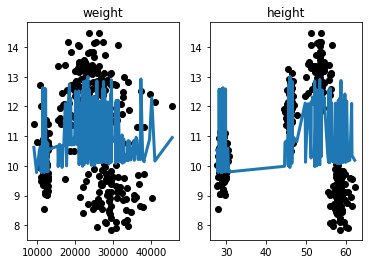

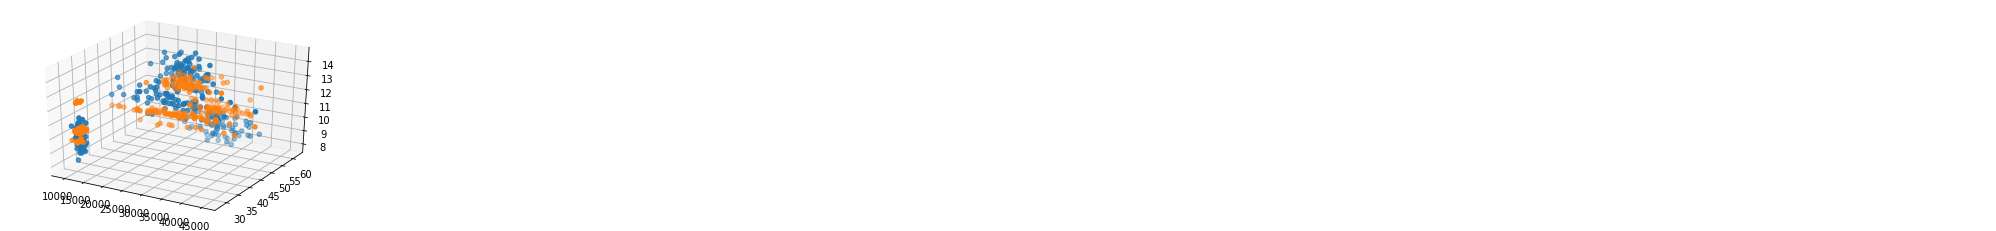

In [16]:
parameters = {
    'alpha': np.arange(0.1, 5, 0.1),
    'fit_intercept': [True, False],
    'normalize': [True, False]
}
model = GridSearchCV(Ridge(), parameters, cv=3, scoring='neg_mean_squared_error')
model.fit(X_train, y_train)
evaluate_regression_model(model, X_test, y_test)
results['simple_ridge'] = best_results(model, parameters)

Models score -0.7373942838868578
Mean Squared Error 0.7373942838868578
Best parameters found {'polynomialfeatures__degree': 2, 'ridge__alpha': 4.5}


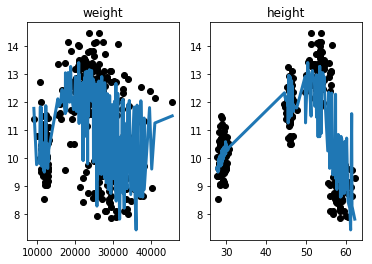

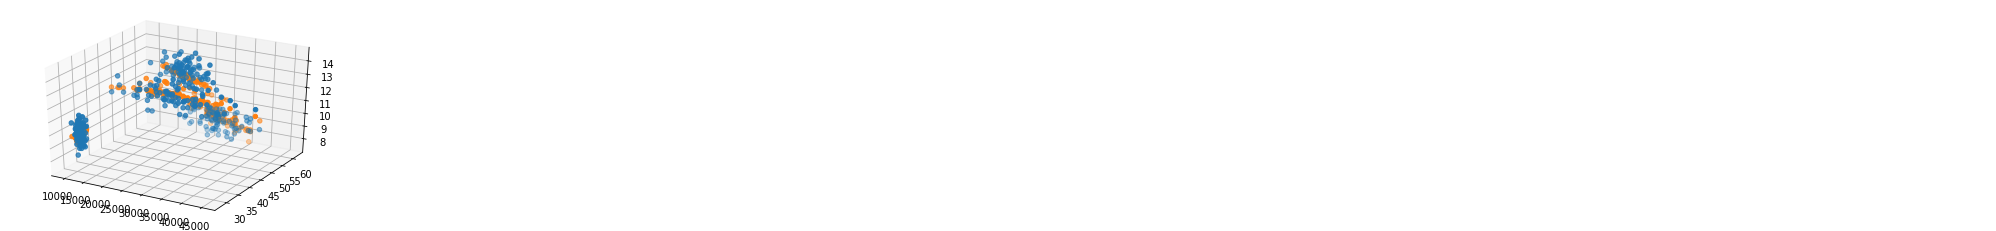

In [17]:
parameters = { 
    'ridge__alpha': np.arange(0.5, 5, 0.5),
    'polynomialfeatures__degree': np.arange(1, 5, dtype=np.int16)
}

model = GridSearchCV(make_pipeline(PolynomialFeatures(), Ridge()), parameters, cv=3, scoring='neg_mean_squared_error')
model.fit(X_train, y_train)
evaluate_regression_model(model, X_test, y_test)
results['polynomial_ridge'] = best_results(model, parameters)

We can see that the model has better results with higher alpha

Models score -0.7378893339728657
Mean Squared Error 0.7378893339728657
Best parameters found {'polynomialfeatures__degree': 2, 'ridge__alpha': 9.5}


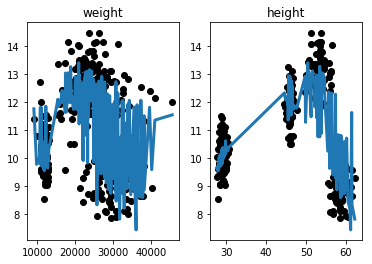

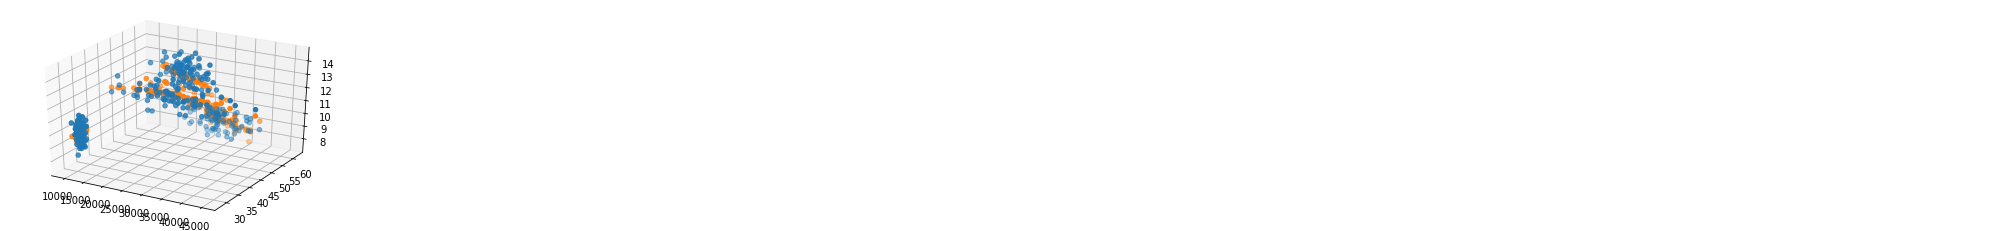

In [18]:
parameters = { 
    'ridge__alpha': np.arange(1, 10, 0.5),
    'polynomialfeatures__degree': np.arange(1, 4, dtype=np.int16)
}

model = GridSearchCV(make_pipeline(PolynomialFeatures(), Ridge()), parameters, cv=3, scoring='neg_mean_squared_error')
model.fit(X_train, y_train)
evaluate_regression_model(model, X_test, y_test)


Models score -0.7469682772586896
Mean Squared Error 0.7469682772586896
Best parameters found {'polynomialfeatures__degree': 2, 'ridge__alpha': 4.1}


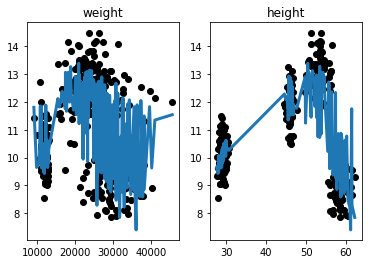

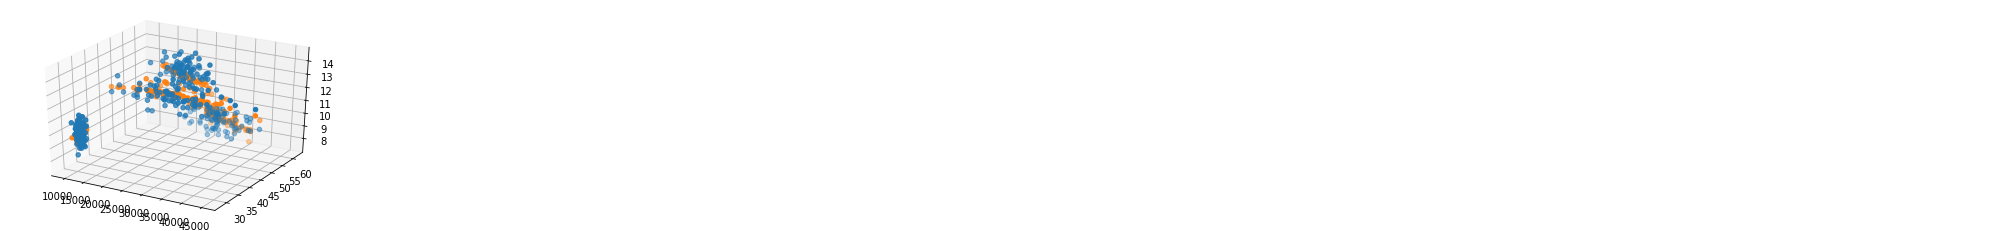

In [19]:
parameters = { 
    'ridge__alpha': np.arange(0.1, 10, 0.5),
    'polynomialfeatures__degree': np.arange(1, 4, dtype=np.int16)
}

model = GridSearchCV(make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge()), parameters, cv=3, scoring='neg_mean_squared_error')
model.fit(X_train, y_train)
evaluate_regression_model(model, X_test, y_test)

results['standard_scaler_polynomial_ridge'] = best_results(model, parameters)

Models score -0.74433898333684
Mean Squared Error 0.74433898333684
Best parameters found {'polynomialfeatures__degree': 2, 'ridge__alpha': 0.03}


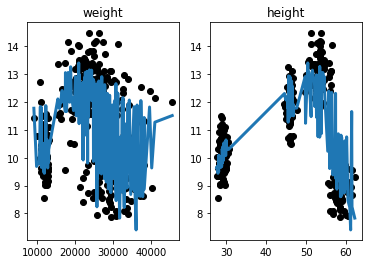

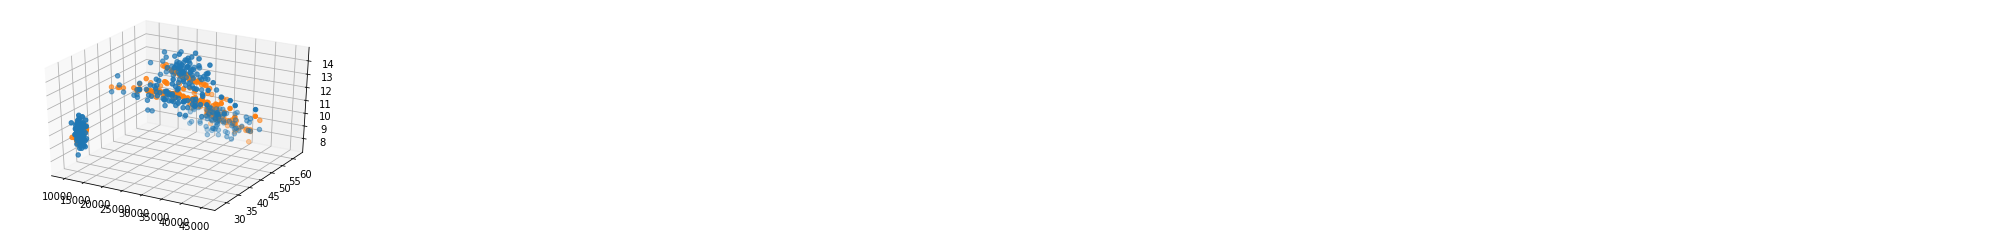

In [20]:
parameters = { 
    'ridge__alpha': np.arange(0.01, 1, 0.01),
    'polynomialfeatures__degree': np.arange(1, 4, dtype=np.int16)
}

model = GridSearchCV(make_pipeline(MinMaxScaler(), PolynomialFeatures(), Ridge()), parameters, cv=3, scoring='neg_mean_squared_error')
model.fit(X_train, y_train)
evaluate_regression_model(model, X_test, y_test)
results['minmax_scaler_polynomial_ridge'] = best_results(model, parameters)

In [ ]:
# results = pd.DataFrame(model.cv_results_)
# results[['param_ridge__alpha', 'param_polynomialfeatures__degree', 'mean_test_score']]
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(results['param_ridge__alpha'], results['param_polynomialfeatures__degree'], results['mean_test_score'])

Lasso Regression

Models score -2.0534301649352047
Mean Squared Error 2.0534301649352047
Best parameters found {'alpha': 0.1}


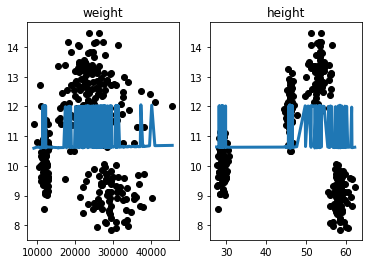

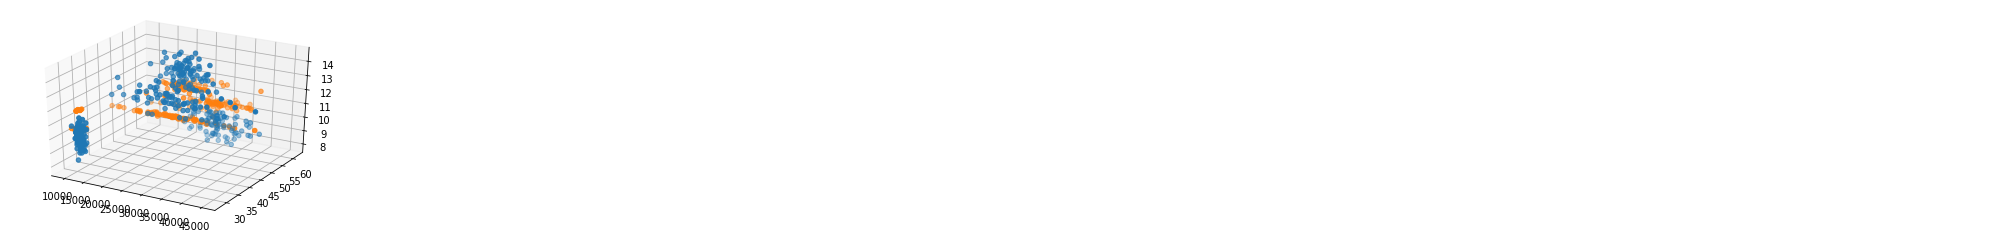

In [21]:
parameters = {
    'alpha': np.arange(0.1, 5, 0.1)
}
model = GridSearchCV(Lasso(), parameters, cv=3, scoring='neg_mean_squared_error')
model.fit(X_train, y_train)
evaluate_regression_model(model, X_test, y_test)
results['simple_lasso'] = best_results(model, parameters)

Models score -0.7517875604116651
Mean Squared Error 0.7517875604116651
Best parameters found {'lasso__alpha': 0.01, 'polynomialfeatures__degree': 2}


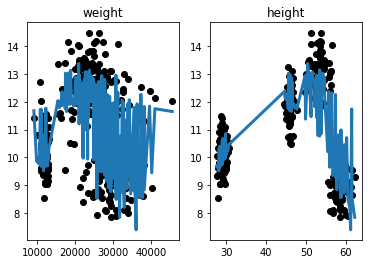

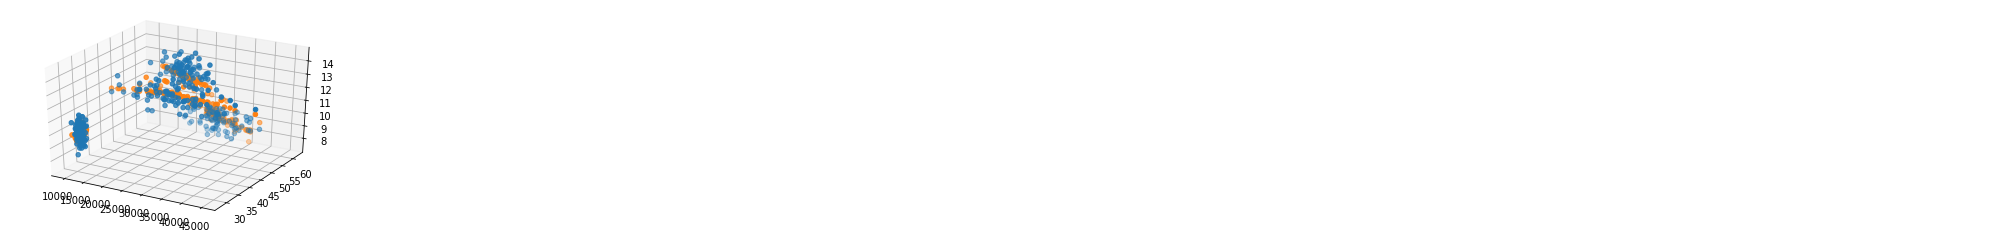

In [27]:
parameters = {
    'lasso__alpha': np.arange(0.01, 0.5, 0.01),
    'polynomialfeatures__degree': np.arange(1, 5, dtype=np.int16)
}
model = GridSearchCV(make_pipeline(PolynomialFeatures(), Lasso()),parameters, cv=3, scoring='neg_mean_squared_error')
model.fit(X_train, y_train)
evaluate_regression_model(model, X_test, y_test)
results['polynomial_lasso'] = best_results(model, parameters)

Models score -0.6699913081813111
Mean Squared Error 0.6699913081813111
Best parameters found {'lasso__alpha': 0.01, 'polynomialfeatures__degree': 4}


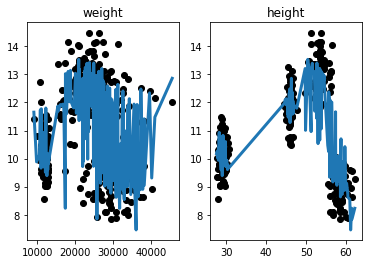

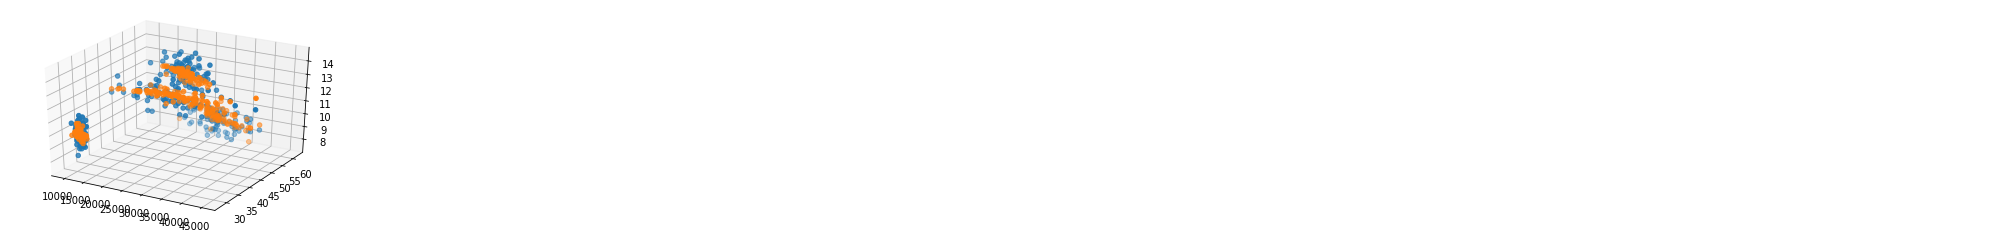

In [26]:
parameters = {
    'lasso__alpha': np.arange(0.01, 0.5, 0.01),
    'polynomialfeatures__degree': np.arange(1, 5, dtype=np.int16)
}
model = GridSearchCV(make_pipeline(StandardScaler(), PolynomialFeatures(), Lasso()),parameters, cv=3, scoring='neg_mean_squared_error')
model.fit(X_train, y_train)
evaluate_regression_model(model, X_test, y_test)
results['standard_scaler_polynomial_lasso'] = best_results(model, parameters)

Models score -0.7448849452412466
Mean Squared Error 0.7448849452412466
Best parameters found {'lasso__alpha': 0.01, 'polynomialfeatures__degree': 4}


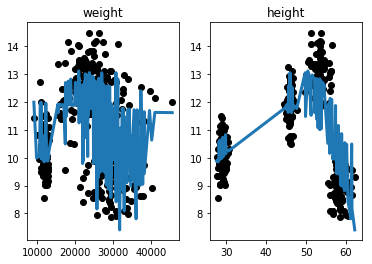

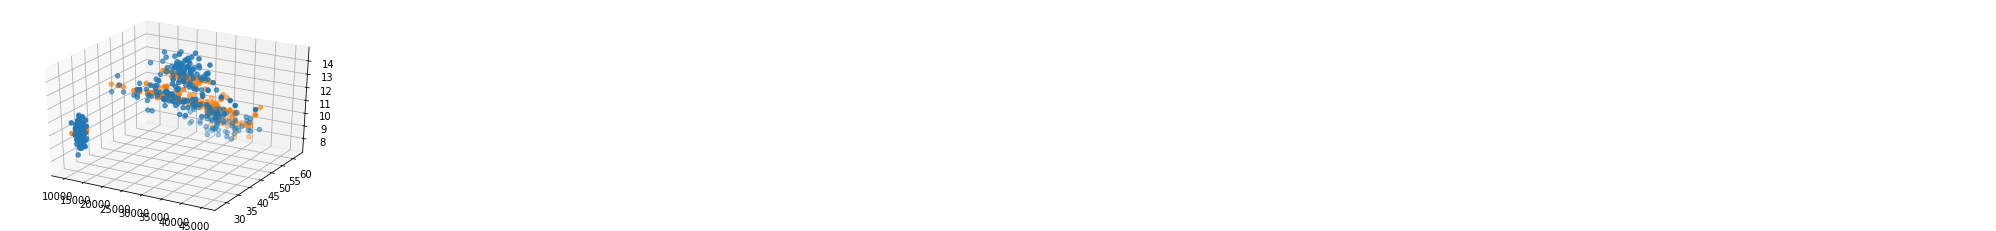

In [28]:
parameters = {
    'lasso__alpha': np.arange(0.01, 0.5, 0.01),
    'polynomialfeatures__degree': np.arange(1, 5, dtype=np.int16)
}
model = GridSearchCV(make_pipeline(MinMaxScaler(), PolynomialFeatures(), Lasso()),parameters, cv=3, scoring='neg_mean_squared_error')
model.fit(X_train, y_train)
evaluate_regression_model(model, X_test, y_test)
results['minmax_scaler_polynomial_lasso'] = best_results(model, parameters)

Models score 0.6956027897749721
Mean Squared Error 0.8267170734053032
Best parameters found {'kneighborsregressor__leaf_size': 1, 'kneighborsregressor__n_neighbors': 4, 'kneighborsregressor__p': 1, 'polynomialfeatures__degree': 2}


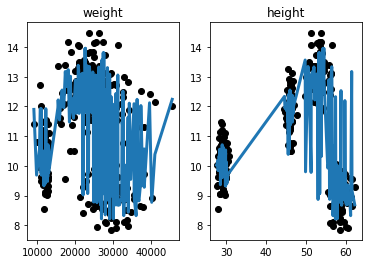

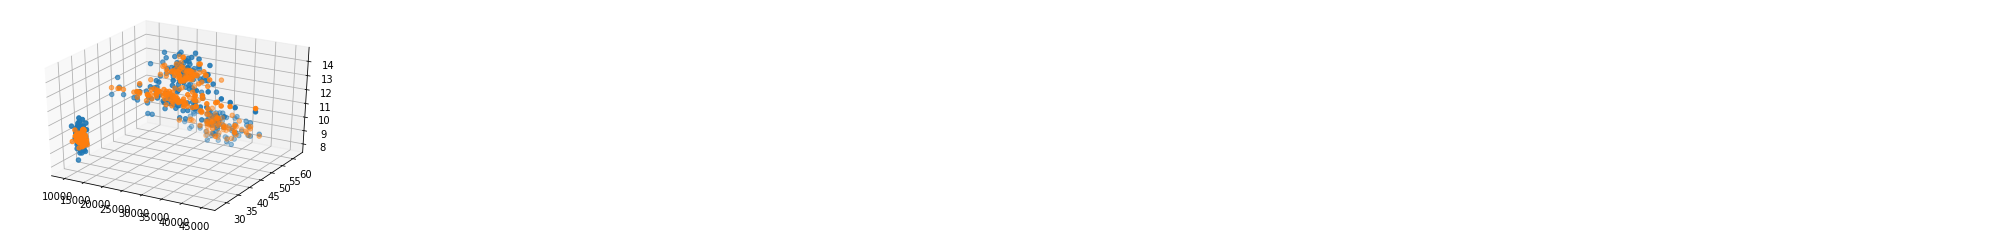

In [29]:
from sklearn.neighbors import KNeighborsRegressor

parameters = {
    'kneighborsregressor__n_neighbors': np.arange(1, 10, dtype=np.int16),
    'polynomialfeatures__degree': np.arange(1, 3, dtype=np.int16),
    'kneighborsregressor__p': [1] ,
    'kneighborsregressor__leaf_size': np.arange(1, 30)
}
model = GridSearchCV(make_pipeline(StandardScaler(), PolynomialFeatures() ,KNeighborsRegressor()),parameters, cv=3)
model.fit(X_train, y_train)
evaluate_regression_model(model, X_test, y_test)

In [35]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(results)


{   'minmax_scaler_polynomial_lasso': [   {   'mean_test_score': -0.7735900354283789,
                                              'param_lasso__alpha': 0.01,
                                              'param_polynomialfeatures__degree': 4,
                                              'rank_test_score': 1},
                                          {   'mean_test_score': -0.7801684410145031,
                                              'param_lasso__alpha': 0.01,
                                              'param_polynomialfeatures__degree': 3,
                                              'rank_test_score': 2},
                                          {   'mean_test_score': -0.8369056209407976,
                                              'param_lasso__alpha': 0.02,
                                              'param_polynomialfeatures__degree': 4,
                                              'rank_test_score': 3},
                                          {   'mean_test_s

From the results we can see that the best performing model is Lasso Regression using polynomial features and the minmax scaler 87% using mean squared error on the test set. Other models using Ridge and Lasso Regression with Polynomial features and using different scaling methods are aroung 74-77%.

In [36]:
X = hot_encoded_data.loc[:, hot_encoded_data.columns.difference(['longevity)', 'breed_name'])]
y = hot_encoded_data['breed_name']

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y)


In [41]:
def evaluate_classification_model(model, X, y):
    print('Models score', model.score(X_test, y_test))
    y_pred = model.predict(X_test)
    print(model.best_params_)
    print(classification_report(y_test, y_pred))

In [42]:
parameters = { 
    'C': np.arange(0.01, 1, 0.01),
}
model = GridSearchCV(LogisticRegression(solver='newton-cg', multi_class='multinomial'), param_grid=parameters)
model.fit(X_train, y_train)
evaluate_classification_model(model, X_test, y_test)

Models score 1.0
{'C': 0.14}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        66
           1       1.00      1.00      1.00        57
           2       1.00      1.00      1.00        50
           3       1.00      1.00      1.00        77

   micro avg       1.00      1.00      1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250



In [45]:
from sklearn.ensemble import RandomForestClassifier
parameters = {
    'n_estimators': np.arange(1, 15)
}
model = GridSearchCV(RandomForestClassifier(), parameters, cv=3)
model.fit(X_train, y_train)
evaluate_classification_model(model, X_test, y_test)

Models score 1.0
{'n_estimators': 10}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        66
           1       1.00      1.00      1.00        57
           2       1.00      1.00      1.00        50
           3       1.00      1.00      1.00        77

   micro avg       1.00      1.00      1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250



In [56]:
parameters = {
    'n_neighbors': np.arange(1, 30),
    'leaf_size': np.arange(1, 30),
}
model = GridSearchCV(KNeighborsClassifier(algorithm='kd_tree'), parameters, cv=3)
model.fit(X_train, y_train)
evaluate_classification_model(model, X_test, y_test)

Models score 0.64
{'leaf_size': 1, 'n_neighbors': 10}
              precision    recall  f1-score   support

           0       0.57      0.65      0.61        66
           1       0.33      0.23      0.27        57
           2       0.50      0.54      0.52        50
           3       0.94      1.00      0.97        77

   micro avg       0.64      0.64      0.64       250
   macro avg       0.59      0.60      0.59       250
weighted avg       0.62      0.64      0.62       250



In [57]:
parameters = {
    'kneighborsclassifier__n_neighbors': np.arange(1, 30),
    'kneighborsclassifier__leaf_size': np.arange(1, 30),
}
model = GridSearchCV(make_pipeline(StandardScaler(), KNeighborsClassifier(algorithm='kd_tree')), parameters, cv=3)
model.fit(X_train, y_train)
evaluate_classification_model(model, X_test, y_test)

Models score 0.984
{'kneighborsclassifier__leaf_size': 1, 'kneighborsclassifier__n_neighbors': 1}
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        66
           1       0.96      0.96      0.96        57
           2       1.00      0.98      0.99        50
           3       0.99      1.00      0.99        77

   micro avg       0.98      0.98      0.98       250
   macro avg       0.98      0.98      0.98       250
weighted avg       0.98      0.98      0.98       250



In [59]:
parameters = {
    'kneighborsclassifier__n_neighbors': np.arange(1, 30),
    'kneighborsclassifier__leaf_size': np.arange(1, 30),
}
model = GridSearchCV(make_pipeline(MinMaxScaler(), KNeighborsClassifier(algorithm='kd_tree')), parameters, cv=3)
model.fit(X_train, y_train)
evaluate_classification_model(model, X_test, y_test)

Models score 0.988
{'kneighborsclassifier__leaf_size': 1, 'kneighborsclassifier__n_neighbors': 1}
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        66
           1       0.98      0.96      0.97        57
           2       1.00      0.98      0.99        50
           3       0.99      1.00      0.99        77

   micro avg       0.99      0.99      0.99       250
   macro avg       0.99      0.99      0.99       250
weighted avg       0.99      0.99      0.99       250



In [ ]:
On the Classification problem

0.988


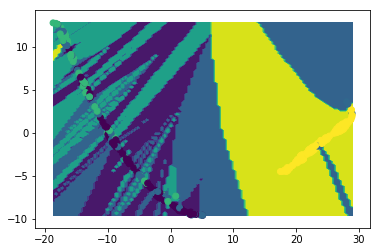

In [60]:
from sklearn.manifold.t_sne import TSNE

# replace the below by your data and model
X_Train_embedded = TSNE(n_components=2).fit_transform(X_test)
# model = LogisticRegression(C=0.05,solver='newton-cg', multi_class='multinomial').fit(X_train,y_train)
y_predicted = model.predict(X_test)
print(model.score(X_test, y_test))
# replace the above by your data and model

# create meshgrid
resolution = 100 # 100x100 background pixels
X2d_xmin, X2d_xmax = np.min(X_Train_embedded[:,0]), np.max(X_Train_embedded[:,0])
X2d_ymin, X2d_ymax = np.min(X_Train_embedded[:,1]), np.max(X_Train_embedded[:,1])
xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))

# approximate Voronoi tesselation on resolution x resolution grid using 1-NN
background_model = KNeighborsClassifier(n_neighbors=1).fit(X_Train_embedded, y_predicted) 
voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
voronoiBackground = voronoiBackground.reshape((resolution, resolution))

#plot
plt.contourf(xx, yy, voronoiBackground)
plt.scatter(X_Train_embedded[:,0], X_Train_embedded[:,1], c=y_test)
plt.show()